In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sparse_shift.plotting import plot_dag
import pickle

## DAGs in triangle MEC

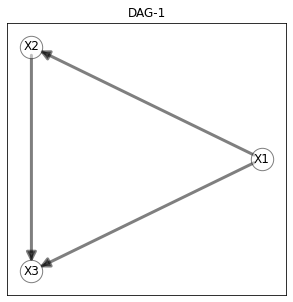

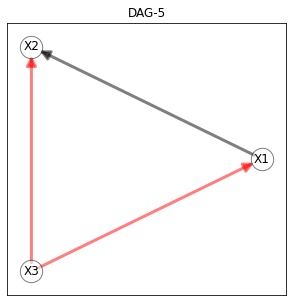

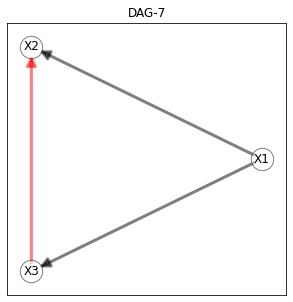

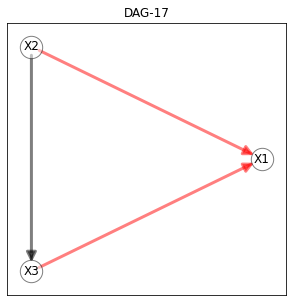

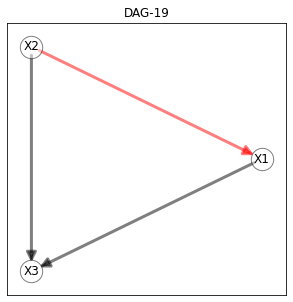

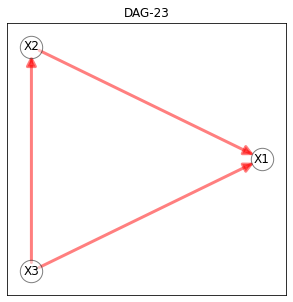

In [16]:
with open("./dag_dict_all_triangles.pkl", "rb") as f:
    dag_dict = pickle.load(f)

# Restrict to MEC
dag_dict = {
    key: dag for key, dag in dag_dict.items() if np.sum(dag) == 3
}

true_parents = dag_dict['DAG-1']
true_dag = 'DAG-1'

for key, dag in dag_dict.items():
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        title=key)

In [7]:
df = pd.read_csv('./icp_triangle_changes.csv', header=[0, 1], delimiter=', ', engine='python')

Targets:  [None,0]


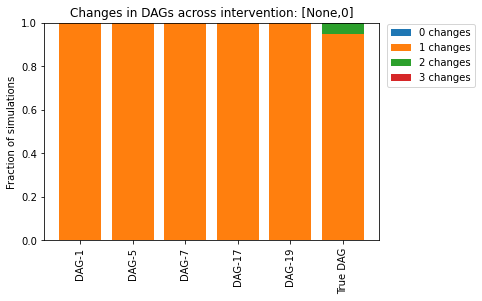

Targets:  [None,1]


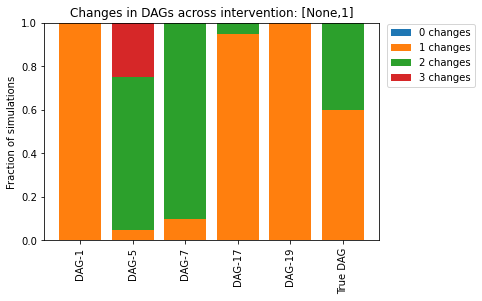

Targets:  [None,2]


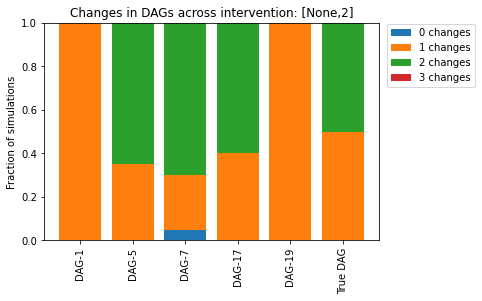

Targets:  [None,(0,1)]


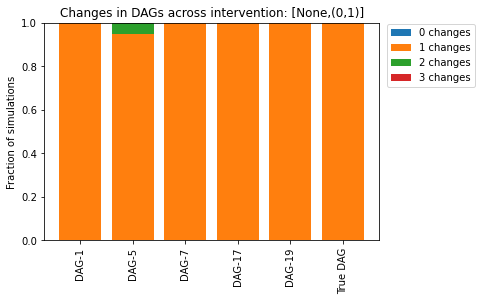

Targets:  [None,(1,2)]


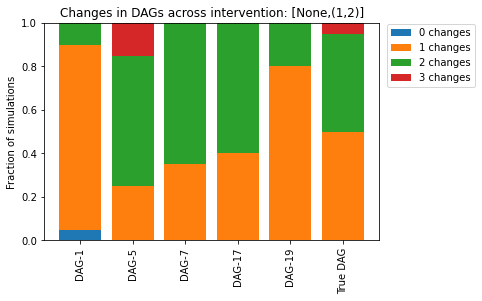

Targets:  [None,(0,2)]


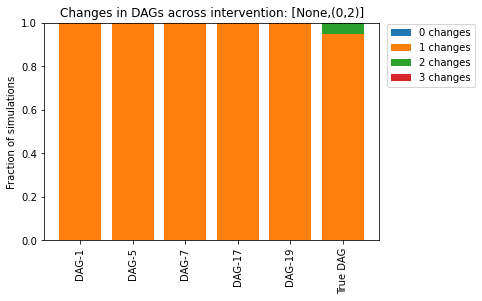

In [79]:
df = pd.read_csv('./icp_triangle_changes_id.csv', header=[0, 1], delimiter=', ', engine='python')
alpha = 0.05 / 3

for params_index in df['Params']['params_index'].unique():
    sub_df = df[df['Params']['params_index'] == params_index]
    targets = sub_df['Params', 'intervention_targets'].iloc[0]
    print('Targets: ', targets)

    changes = np.asarray([
        np.sum(sub_df[key].to_numpy() < alpha, axis=1)
        for key in dag_dict.keys()
    ])

    counts = [
        np.mean(changes == val, axis=1)
        for val in [0, 1, 2, 3]
    ]
    labels = list(dag_dict.keys())
    labels[np.where(np.asarray(labels) == 'DAG-23')[0][0]] = 'True DAG'

    fig, ax = plt.subplots()

    bottom = np.zeros(counts[0].shape[0])
    for i in range(len(counts)):
        ax.bar(labels, counts[i], bottom=bottom,
           label=f'{i} changes')
        bottom += counts[i]

    ax.set_ylabel('Fraction of simulations')
    plt.xticks(rotation=90, ha="center")
    ax.set_title(f'Changes in DAGs across intervention: {targets}')
    ax.legend(bbox_to_anchor=(1.01, 1.02))

    plt.show()

Targets:  [None,0]


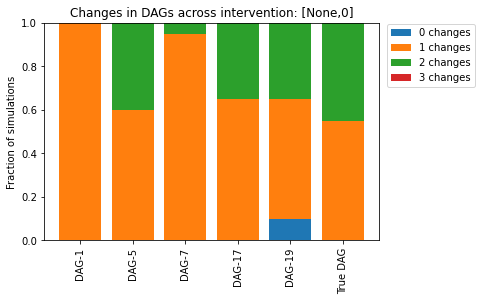

Targets:  [None,1]


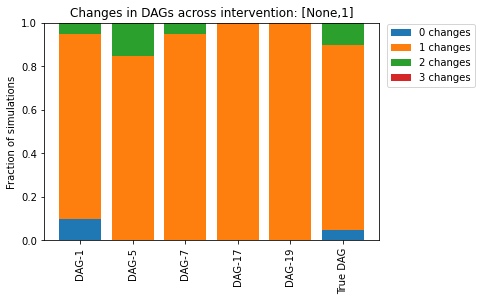

Targets:  [None,2]


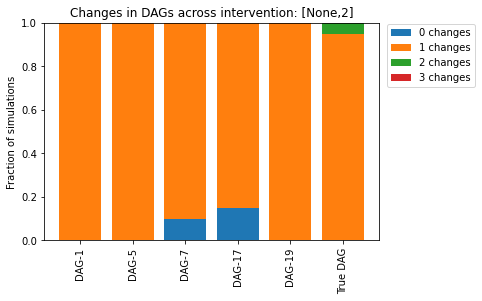

Targets:  [None,(0,1)]


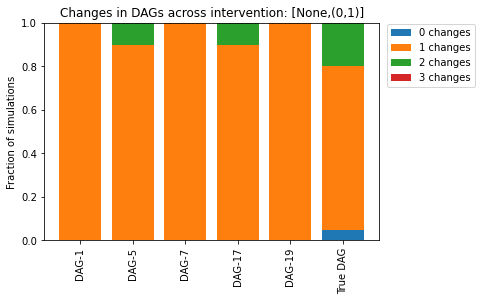

Targets:  [None,(1,2)]


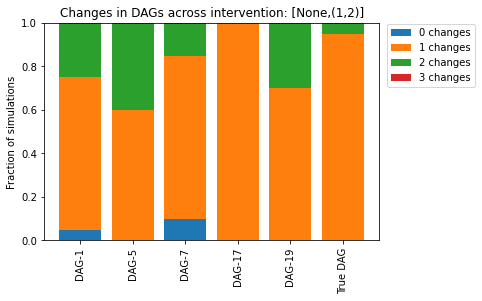

Targets:  [None,(0,2)]


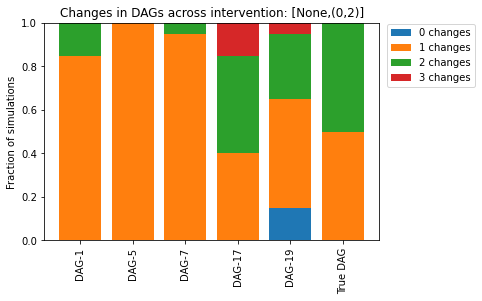

In [80]:
df = pd.read_csv('./icp_triangle_changes.csv', header=[0, 1], delimiter=', ', engine='python')
alpha = 0.05 / 3

for params_index in df['Params']['params_index'].unique():
    sub_df = df[df['Params']['params_index'] == params_index]
    targets = sub_df['Params', 'intervention_targets'].iloc[0]
    print('Targets: ', targets)

    changes = np.asarray([
        np.sum(sub_df[key].to_numpy() < alpha, axis=1)
        for key in dag_dict.keys()
    ])

    counts = [
        np.mean(changes == val, axis=1)
        for val in [0, 1, 2, 3]
    ]
    labels = list(dag_dict.keys())
    labels[np.where(np.asarray(labels) == 'DAG-23')[0][0]] = 'True DAG'

    fig, ax = plt.subplots()

    bottom = np.zeros(counts[0].shape[0])
    for i in range(len(counts)):
        ax.bar(labels, counts[i], bottom=bottom,
           label=f'{i} changes')
        bottom += counts[i]

    ax.set_ylabel('Fraction of simulations')
    plt.xticks(rotation=90, ha="center")
    ax.set_title(f'Changes in DAGs across intervention: {targets}')
    ax.legend(bbox_to_anchor=(1.01, 1.02))

    plt.show()

In [68]:
changes.shape

(6, 20)